In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/TugasBesar_MachineLearning"

In [ ]:
%cd /content/drive/MyDrive/TugasBesar_MachineLearning

/content/drive/MyDrive/TugasBesar_MachineLearning


In [ ]:
!ls

 chest_xray		 model.png
 first_model.json	'person1661_virus_2873 (1).jpeg'
 kaggle.json		'person1661_virus_2873 (2).jpeg'
 model_6.h5		'person1661_virus_2873 (3).jpeg'
 model_deploy.h5	'person1661_virus_2873 (4).jpeg'
 model-newsplit_3.h5	 person1661_virus_2873.jpeg
 model-newsplit_3.json


In [ ]:
#Import library yang dibutuhkan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Conv2D, MaxPool2D
from tensorflow.keras.layers import Dropout, SpatialDropout2D
from keras.layers import GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Flatten
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import shutil

In [ ]:
#Pengambilan Data
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
!pip install split-folders

In [ ]:
mainFolder="/content/drive/MyDrive/TugasBesar_MachineLearning/chest_xray"
dataFolder="/content/drive/MyDrive/TugasBesar_MachineLearning/chest_xray/chest_xray/allData"

In [ ]:
#import splitfolders
#splitfolders.ratio(dataFolder, output=mainFolder, seed=1337, ratio=(.7,.1,.2),group_prefix=None)

In [ ]:
train = get_training_data('/content/drive/MyDrive/TugasBesar_MachineLearning/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/TugasBesar_MachineLearning/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/TugasBesar_MachineLearning/chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


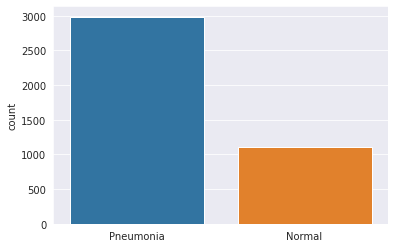

In [ ]:
#Analisis Data
cekData = []
for i in train:
    if(i[1] == 0):
        cekData.append("Pneumonia")
    else:
        cekData.append("Normal")
sns.set_style('darkgrid')
sns.countplot(cekData) 

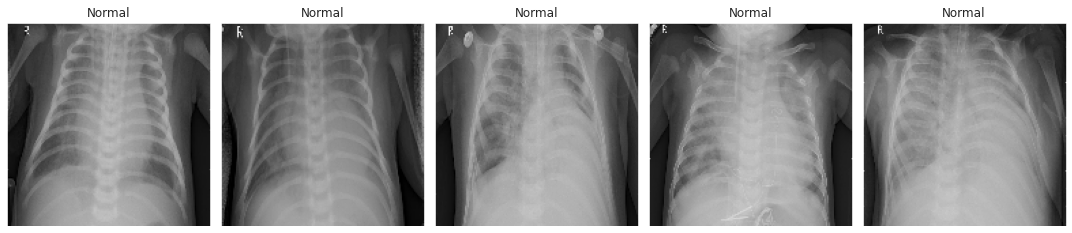

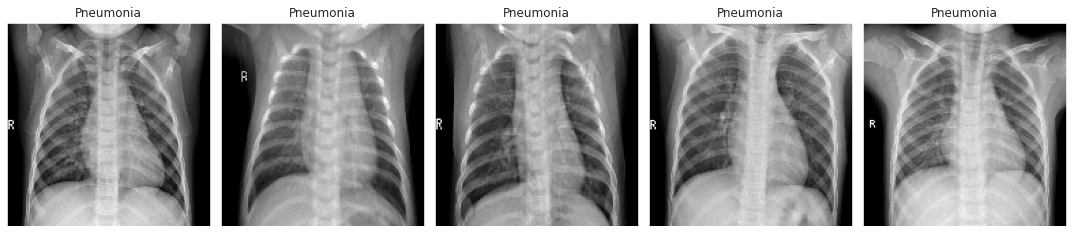

In [ ]:
#Print sampel data dari masing masing label
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
        img = train[i][0]
        ax.imshow(img, cmap='gray')
        ax.set_title("Normal")
fig.tight_layout()    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
        img = train[-(i+1)][0]
        ax.imshow(img, cmap='gray')
        ax.set_title("Pneumonia")
fig.tight_layout()
plt.show()

In [ ]:
#Splitting Data
#X = Fitur
#Y = Label
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
#Normalisasi Data
#Biar dalam rentang 0-1
x_train = np.array(x_train) / 255 #255 = nilai max
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
#Resize Data
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set rata rata input menjadi 0 di atas dataset
        samplewise_center=False,  # set setiap rata rata sampel menjadi 0
        featurewise_std_normalization=False,  # membagi input dengan std dari dataset
        samplewise_std_normalization=False,  # bagi setiap input dengan std
        zca_whitening=False,  # ZCA whitening
        rotation_range = 30,  # melakukan rotate gambar secara acak dalam rentang derajat 0 -180
        zoom_range = 0.2, # melakukan zoom gambar secara acak 
        width_shift_range=0.1,  # menggeser gambar secara acak secara horizontal
        height_shift_range=0.1,  # menggeser gambar secara acak secara vertikal
        horizontal_flip = True,  # membalik gambar horizontal secara acak
        vertical_flip=False)  # melakukan membalik gambar vertikal secara acak

In [ ]:
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

In [ ]:
lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
print(y_train)

[0 0 0 ... 1 1 1]


In [ ]:
model3 = Sequential()
model3.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model3.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model3.add(Dropout(0.1))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model3.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model3.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model3.add(Dropout(0.15))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model3.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model3.add(Flatten())
model3.add(Dense(units = 128 , activation = 'relu'))
model3.add(Dropout(0.2))

model3.add(Dense(units = 1 , activation = 'sigmoid'))
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [ ]:
model3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model_3 = model3.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
128/128 [==============================] - 24s 86ms/step - loss: 0.2758 - acc: 0.9131 - val_loss: 7.3037 - val_acc: 0.7299
Epoch 2/100
128/128 [==============================] - 10s 77ms/step - loss: 0.1375 - acc: 0.9506 - val_loss: 4.9864 - val_acc: 0.7299
Epoch 3/100
128/128 [==============================] - 10s 77ms/step - loss: 0.1309 - acc: 0.9569 - val_loss: 3.3749 - val_acc: 0.7299
Epoch 4/100
128/128 [==============================] - 10s 76ms/step - loss: 0.0995 - acc: 0.9631 - val_loss: 0.5570 - val_acc: 0.8231
Epoch 5/100
128/128 [==============================] - 10s 77ms/step - loss: 0.0940 - acc: 0.9628 - val_loss: 0.1777 - val_acc: 0.9385
Epoch 6/100
128/128 [==============================] - 10s 77ms/step - loss: 0.0742 - acc: 0.9719 - val_loss: 0.1515 - val_acc: 0.9402
Epoch 7/100
128/128 [==============================] - 10s 77ms/step - loss: 0.0662 - acc: 0.9765 - val_loss: 0.1057 - val_acc: 0.9598
Epoch 8/100
128/128 [==============================] - 

In [ ]:
from sklearn.metrics import classification_report

pred = model3.predict(x_test)
labels = (pred > 0.5).astype(np.int)

print(classification_report(y_test, labels))


              precision    recall  f1-score   support

           0       0.96      0.99      0.98       854
           1       0.98      0.88      0.93       316

    accuracy                           0.96      1170
   macro avg       0.97      0.94      0.95      1170
weighted avg       0.96      0.96      0.96      1170



In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing import image
from google.colab import files

In [ ]:
model4 = Sequential()
model4.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model4.add(BatchNormalization())
model4.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))

model4.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model4.add(Dropout(0.1))
model4.add(BatchNormalization())
model4.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))

model4.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model4.add(BatchNormalization())
model4.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))

model4.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model4.add(Dropout(0.15))
model4.add(BatchNormalization())
model4.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))

model4.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model4.add(Dropout(0.2))
model4.add(BatchNormalization())
model4.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))

model4.add(Flatten())
model4.add(Dense(units = 128 , activation = 'relu'))
model4.add(Dropout(0.2))

model4.add(Dense(units = 1 , activation = 'sigmoid'))
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_10 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 average_pooling2d_5 (Averag  (None, 75, 75, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_11 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_8 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_11 (Bat  (None, 75, 75, 64)      

In [ ]:
model4.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model_4 = model4.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
128/128 [==============================] - 11s 77ms/step - loss: 0.2455 - acc: 0.9092 - val_loss: 0.6156 - val_acc: 0.6786
Epoch 2/100
128/128 [==============================] - 10s 75ms/step - loss: 0.1474 - acc: 0.9447 - val_loss: 1.6274 - val_acc: 0.3299
Epoch 3/100
128/128 [==============================] - 9s 74ms/step - loss: 0.1291 - acc: 0.9550 - val_loss: 0.9461 - val_acc: 0.5145
Epoch 4/100
128/128 [==============================] - 10s 74ms/step - loss: 0.1102 - acc: 0.9584 - val_loss: 0.9490 - val_acc: 0.6641
Epoch 5/100
128/128 [==============================] - 10s 74ms/step - loss: 0.0977 - acc: 0.9645 - val_loss: 0.1331 - val_acc: 0.9444
Epoch 6/100
128/128 [==============================] - 10s 74ms/step - loss: 0.0857 - acc: 0.9709 - val_loss: 0.3972 - val_acc: 0.8538
Epoch 7/100
128/128 [==============================] - 9s 74ms/step - loss: 0.0870 - acc: 0.9689 - val_loss: 0.1535 - val_acc: 0.9333
Epoch 8/100
128/128 [==============================] - 10

In [ ]:
from sklearn.metrics import classification_report

pred = model4.predict(x_test)
labels = (pred > 0.5).astype(np.int)

print(classification_report(y_test, labels))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       854
           1       0.93      0.95      0.94       316

    accuracy                           0.97      1170
   macro avg       0.95      0.96      0.96      1170
weighted avg       0.97      0.97      0.97      1170



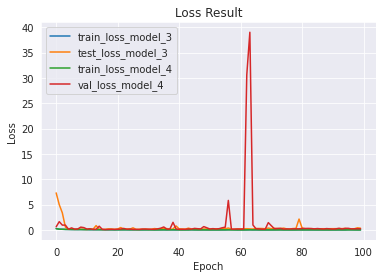

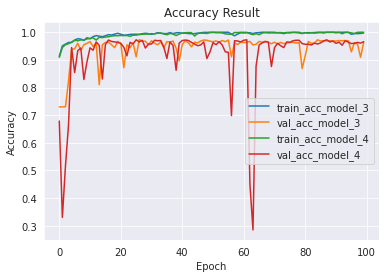

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model_3.history["loss"], label="train_loss_model_3")
plt.plot(model_3.history["val_loss"], label="test_loss_model_3")
plt.plot(model_4.history["loss"], label="train_loss_model_4")
plt.plot(model_4.history["val_loss"], label="val_loss_model_4")
plt.title("Loss Result")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(model_3.history["acc"], label="train_acc_model_3")
plt.plot(model_3.history["val_acc"], label="val_acc_model_3")
plt.plot(model_4.history["acc"], label="train_acc_model_4")
plt.plot(model_4.history["val_acc"], label="val_acc_model_4")
plt.title("Accuracy Result")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
import json

In [ ]:
save_dir = '/content/drive/MyDrive/TugasBesar_MachineLearning'

#json.dump(model3.history, open(save_dir + '/model-newsplit_3.json', 'w'))
model3.save(save_dir + '/model-newsplit_3_withoutLRS.h5')

In [ ]:
save_dir = '/content/drive/MyDrive/TugasBesar_MachineLearning'

#json.dump(model_3.history, open(save_dir + '/model-newsplit_3.json', 'w'))
model4.save(save_dir + '/model-newsplit_4_withoutLRS.h5')